In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot as plt
# assert torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Problem 1
Download the CIFAR10 training and test datasets.
Transform them into tensors, normalize them as described above in the code, and create DataLoaders for each one. 
For the training set, use a batch size of 32, and for the test set, use a batch size of 1.



In [2]:
# classes inside dataset
classes = ('airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks')

def download_dataset(shuffle=True):

    # Normalize data and transform it to a tensor
    transform = transforms.Compose(
                                    [transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                   )


    # get train data
    train_data = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
    # get test data
    test_data = datasets.CIFAR10('../data', train=False, download=True, transform=transform)

    # split data into batches
    train_loader = DataLoader(train_data, batch_size=32, shuffle=shuffle)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=shuffle)

    return train_loader, test_loader 



In [3]:
train_loader, test_loader = download_dataset()
dataiter = iter(train_loader)
# dataiter_test = iter(test_loader)
images, labels = dataiter.next()
# images_test, labels_test = dataiter_test.next()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


# Problem 2

Create a convolution model class convoles an image of size $3\times 32 \times 32$ into a 1D tensor that represents the $10$ classes.
The model should have at least three convolution layers, each followed by an activation function, and include at least two linear layers and one maxpool layer.
Select channels and kernel sizes so that you get at least $50,000$ parameters.

Calculate and print the number of learnable parameters in your model.

Initialize your model and move it to the device.
Run the model on a single image to make sure there are no errors.

In [4]:
class ConvolutionModel(nn.Module):

    def __init__(self):
        super(ConvolutionModel, self).__init__()

        # first convolutional layer
        # num of features: (3*5*5+1)*6 = 550
        # output size: 6x28x28
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # relu activation function
        # preserves size
        self.relu = nn.ReLU()

        # maxpool layer
        # num of features: 0
        # output size: 6x14x14
        self.maxpool = nn.MaxPool2d(kernel_size=2) 

        # second convolutional layer
        # num of features: (6*3*3+1)*10 = 550
        # output size: 10x12x12
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3)

        # third convolutional layer
        # num of features: (10*2*2 +1)*14 = 574
        # output size: 14x11x11
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=14, kernel_size=2)


        # first linear layer
        # num of features (14*11*11 +1)*29 = 49,155
        # outputsize = 1x35
        self.linear1 = nn.Linear(in_features=14 * 11 * 11, out_features=29)
        # second linear layer
        # num of features (35 + 1)*10 = 360
        # outputisze = 1x10
        self.linear2 = nn.Linear(in_features = 29, out_features = 10)

        # flattens before applying linear layer1        
        self.flatten = nn.Flatten()


    # call the layers on an image
    def forward(self, x):
        output = self.relu(self.conv1(x))
        output = self.maxpool(output)
        output = self.relu(self.conv2(output))
        output = self.relu(self.conv3(output))
        output = self.flatten(output)
        output = self.linear1(output) 

        return self.linear2(output)

In [5]:
class ConvolutionModel2(nn.Module):

    def __init__(self):
        super(ConvolutionModel2, self).__init__()

        # first convolutional layer
        # num of features: (3*5*5+1)*6 
        # output size: 6x28x28
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # relu activation function
        # preserves size
        self.relu = nn.ReLU()

        # maxpool layer
        # num of features: 0
        # output size: 6x14x14
        self.maxpool = nn.MaxPool2d(kernel_size=2) 

        # second convolutional layer
        # num of features: (6*3*3+1)*10
        # output size: 10x12x12
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3)

        # first linear layer
        # num of features: (10*12*12 +1)*6*32*32 
        # output size:1x(6*32*32)
        self.linear1 = nn.Linear(in_features = 10*12*12, out_features=6*32*32)


        # third convolutional layer
        # num of features: (10*6*6 +1)*10
        # output size: 10x27x27
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=6)

        # second linear layer
        # num of features: (10*27*27 +1)*10
        # outputsize = 1x10
        self.linear2 = nn.Linear(in_features=10*27*27, out_features=10 )

        # flattens before applying linear layer1        
        self.flatten = nn.Flatten()

    def reshape(self, x):
        return torch.reshape(x, (1, 6, 32, 32))

    # call the layers on an image
    def forward(self, x):
        output = self.relu(self.conv1(x))
        output = self.maxpool(output)
        output = self.relu(self.conv2(output))
        output = self.flatten(output)
        output = self.linear1(output)
        output = self.reshape(output)
        output = self.relu(self.conv3(output))
        output = self.flatten(output)
        return self.linear2(output)

In [6]:
model = ConvolutionModel()
model = model.to(device)
im = images[0].unsqueeze(0).to(device)
out = model.forward(im)

print(out)

tensor([[-0.1208,  0.0011, -0.1401,  0.1946, -0.0370,  0.1914, -0.0391,  0.0395,
         -0.1493, -0.0582]], device='cuda:0', grad_fn=<AddmmBackward0>)


# Problem 3

Train the model by looping through the training data. Inside the loop, you should
1. Zero out the gradients.
2. Run the model on the inputs.
3. Calculate the loss on the model output and the actual label.
4. Backpropogate the error.
5. Optimize.

Run the loop for 10 epochs. At the end of each epoch, calculate the mean loss of the
training data for that epoch. Then calculate the accuracy of the model on the test data. Since
the model is no longer training, it needs to be set to evaluation mode using model.eval().
To resume training at the beginning of the next epoch, set the model to training mode using
model.train().

You should have around $50\%$ accuracy at the end of $10$ epochs.

Plot the epochs v. mean training loss each epoch and the epochs v. accuracy.


In [7]:
def train_conv_model_1():
    # instantiate modmel, objective, and optimizer
    model = ConvolutionModel()
    model = model.to(device)
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # now run 10 epochs looping through all training data
    mean_loss = []
    accuracy = []
    for epoch in range(10):
        # epoch loss list
        loop = tqdm(total=len(train_loader), position = 0)
        epoch_loss = []
        for batch, (x, y_truth) in enumerate(train_loader):
            # get x, labels
            x, y_truth = x.to(device), y_truth.to(device)
            # zero out gradients
            optimizer.zero_grad()
            # run the model

            outputs = model.forward(x)
            # calculate the loss
            loss = objective(outputs, y_truth)

            epoch_loss.append(loss.item())
            # compute the gradients
            loss.backward()
            # optimize and update the weights
            optimizer.step()
            # set loop description and update
            loop.set_description('loss:{:.4f}'.format(loss.item()))
            loop.update()

        # calculate mean loss for that epoch
        mean_loss.append(np.mean(epoch_loss))

        # now we evaluate the accuracy
        model.eval()
        curr_accuracy = 0
        for batch, (x, y_truth) in enumerate(test_loader):
            x, y_truth = x.to(device), y_truth.to(device)
            out = model.forward(x)
            if (torch.argmax(out) == y_truth).item():
                curr_accuracy += 1

        accuracy.append(curr_accuracy / 10000)
        model.train()

    return model, accuracy, mean_loss, objective, optimizer

def train_model_conv_2():
    # instantiate modmel, objective, and optimizer
    model = ConvolutionModel()
    model = model.to(device)
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # now run 10 epochs looping through all training data
    mean_loss = []
    accuracy = []
    for epoch in range(10):
        # epoch loss list
        loop = tqdm(total=len(train_loader), position = 0)
        epoch_loss = []
        for batch, (x, y_truth) in enumerate(train_loader):
            # get x, labels
            x, y_truth = x.to(device), y_truth.to(device)
            # zero out gradients
            optimizer.zero_grad()
            # run the model
            outputs = model.forward(x[0].unsqueeze(0))
            for t in x[1:]:
                out = model.forward(t.unsqueeze(0))
                outputs = torch.cat((outputs, out), 0)

            outputs = model.forward(x)
            # calculate the loss
            loss = objective(outputs, y_truth)

            epoch_loss.append(loss.item())
            # compute the gradients
            loss.backward()
            # optimize and update the weights
            optimizer.step()
            # set loop description and update
            loop.set_description('loss:{:.4f}'.format(loss.item()))
            loop.update()

        # calculate mean loss for that epoch
        mean_loss.append(np.mean(epoch_loss))

        # now we evaluate the accuracy
        model.eval()
        curr_accuracy = 0
        for batch, (x, y_truth) in enumerate(test_loader):
            x, y_truth = x.to(device), y_truth.to(device)
            out = model.forward(x)
            if (torch.argmax(out) == y_truth).item():
                curr_accuracy += 1

        accuracy.append(curr_accuracy / 10000)
        model.train()

    return model, accuracy, mean_loss, objective, optimizer
  
def train_model(method=1):
    if method == 1:
        return train_conv_model_1()

    elif method == 2:
        return train_model_conv_2()
    else:
        raise NotImplementedError("Not Implemented.")


In [8]:
model, accuracy, mean_loss, objective, optimizer = train_model(method=1)

loss:1.2602: 100%|██████████| 1563/1563 [00:46<00:00, 33.97it/s]


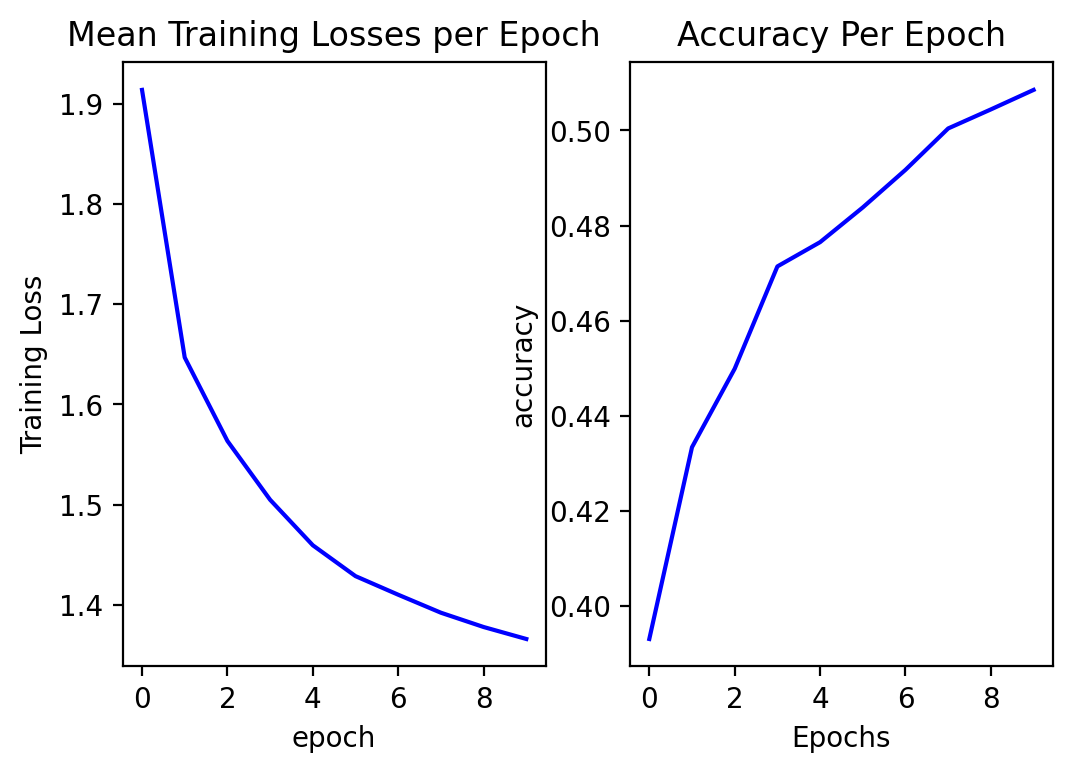

In [9]:
def plot_figures(mean_loss, accuracy):
    fig = plt.figure()
    fig.set_dpi(200)
    ax = fig.add_subplot(121)
    ax.plot(np.arange(10), mean_loss, 'b-')
    ax.set_xlabel('epoch')
    ax.set_ylabel('Training Loss')
    ax.set_title('Mean Training Losses per Epoch')
    ax = fig.add_subplot(122)
    ax.plot(np.arange(10), accuracy, 'b-')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('accuracy')
    ax.set_title('Accuracy Per Epoch')
    plt.show()
    return

plot_figures(mean_loss, accuracy)

# Problem 4

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [10]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image adding clipping to maintain [-1,1] range
    return torch.clamp(perturbed_image, -1, 1)

Files already downloaded and verified
Files already downloaded and verified


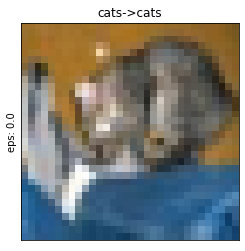

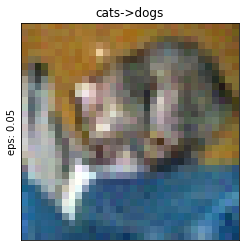

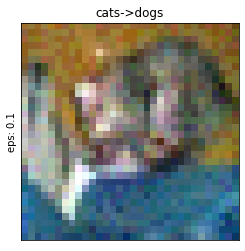

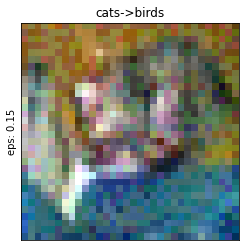

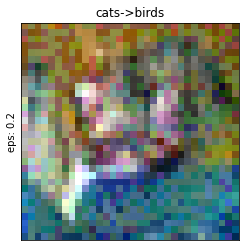

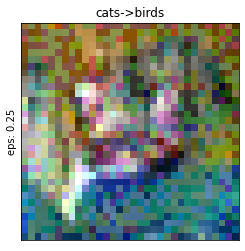

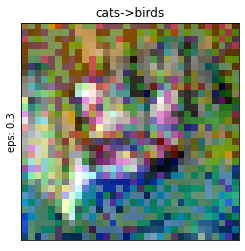

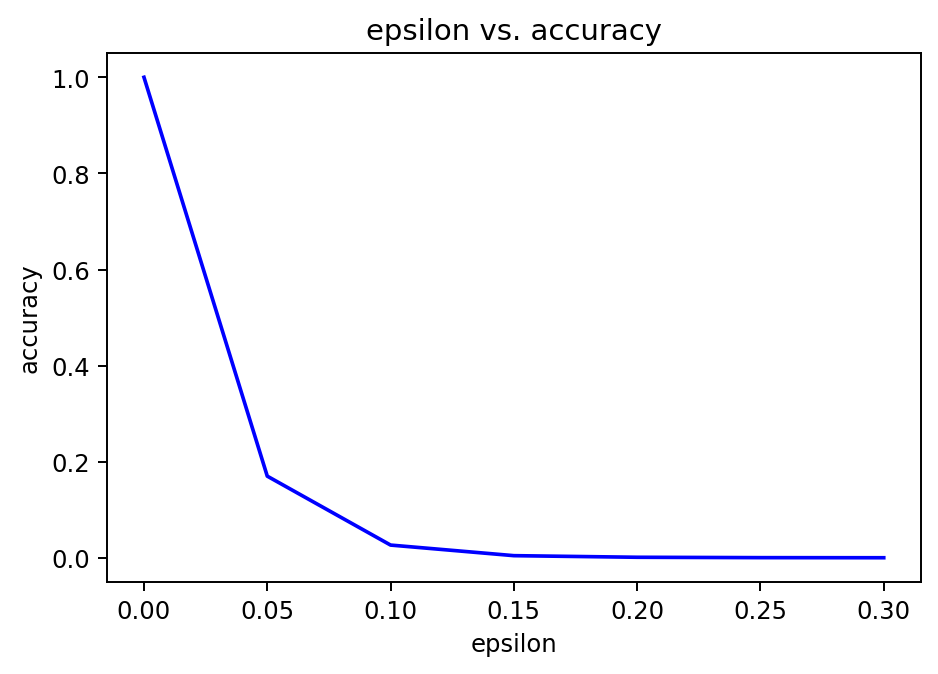

In [12]:
def adversarialAttack(model, objective, optimizer, dataloader, eps):
    accuracy = 0
    enter = 0
    for batch, (x, y_truth) in enumerate(test_loader):
        x, y_truth = x.to(device), y_truth.to(device)
        x.requires_grad = True
        out = model.forward(x)

        if not ((torch.argmax(out) == y_truth).item()):
            continue

        enter += 1
        # update loss
        loss = objective(out, y_truth)
        # zero out gradinet
        optimizer.zero_grad()
        # backward step
        loss.backward()
        # compute data grad
        data_grad = x.grad.data
        # get perturbed ata
        perturbed_data = fgsm_attack(x, eps, data_grad)

        # test
        out = model.forward(perturbed_data)

        # plot first batch
        if enter == 1:
            img = perturbed_data.squeeze().detach().cpu().numpy()
            img /= 2 
            img += 0.5 
            plt.imshow(np.transpose(img, (1, 2, 0)))
            plt.title(str(classes[y_truth.item()] + '->' + str(classes[torch.argmax(out).item()])))
            plt.ylabel('eps: ' + str(eps))
            plt.xticks([])
            plt.yticks([])
            plt.show()

        if (torch.argmax(out) == y_truth).item():
            accuracy += 1

    return accuracy / enter


def problem4(model, objective, optimizer, dataloader):
    # change model to eval mode
    model.eval()
    # evals
    eps_vals = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
    # accuracy
    accuracy = [adversarialAttack(model, objective, optimizer, dataloader, eps) for eps in eps_vals]

    fig = plt.figure()
    fig.set_dpi(175)
    ax = fig.add_subplot(111)
    ax.plot(eps_vals, accuracy, 'b-')
    ax.set_xlabel('epsilon')
    ax.set_ylabel('accuracy')
    ax.set_title('epsilon vs. accuracy')
    plt.show()

train_loader, test_loader = download_dataset(shuffle=False)
problem4(model, objective, optimizer, test_loader)